# Ship Detection using Faster R-CNN

## Importing libraries

The necessary libraries required for implementing the Faster R-CNN model are imported in the code block below.

In [4]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
# from tensorflow.python import keras
from keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import *


start_time = time.perf_counter()
print("Checking System\n")

SEED = 1337
print('Tensorflow version : {}'.format(tf.__version__))

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

end_time = time.perf_counter()

print(f"\nSystem check done in {end_time - start_time:0.4f} seconds")
print("System Checked!")

Checking System

Tensorflow version : 2.11.0-dev20220812
Number of replicas: 1
2.11.0-dev20220812

System check done in 0.0104 seconds
System Checked!


## Utility functions

1. show_final_history - For plotting the loss and accuracy of the training and validation datasets
2. plot_confusion_matrix - For plotting the percentage of true positives per class for a better feel of how the model predicted the data

In [5]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [6]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

## Loading the images

The images from the SatelliteImageryofShips is loaded into numpy arrays, with labels [0,1] corresponding to the classes no-ship and ship. The data was loaded into numpy arrays as data augmentation and upsampling/downsampling is easier to perform.

In [16]:
datasets = ['./SatelliteImageryofShips/']

class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [17]:
def load_data():
    images, labels = [], []
    
    for dataset in datasets:
        
        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                
                img_path = os.path.join(dataset,folder,file)
                
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (48,48))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass
    
    return (images, labels)
    pass

In [18]:
(images, labels) = load_data()
images.shape, labels.shape

100%|██████████| 1000/1000 [00:01<00:00, 566.53it/s]


((4000, 48, 48, 3), (4000,))

## EDA of dataset

1. bar-plot - Bar plot is made to find the count of images per class
2. pie-plot - Pie plot is drawn to find the percentage of class distribution in the dataset

In [19]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-ship,3000
ship,1000


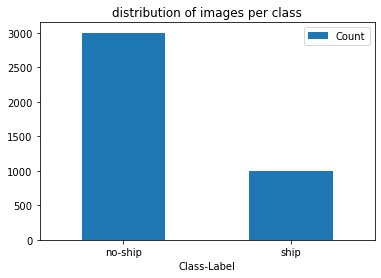

In [20]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

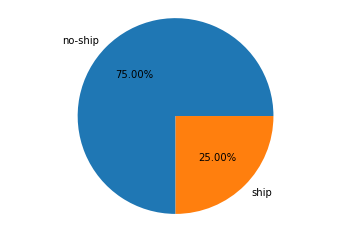

In [21]:
plt.pie(count,
        explode=(0,0),
        labels=class_names,
        autopct="%1.2f%%")
plt.axis('equal');

Due to imbalance in dataset, upsampling is done on the minority class, by randomly duplicating images until the 2 classes have comparable distribution in the dataset. After this is done, the dataset will be split into the training, testing and validation sets by randomly shuffling them and then splitting.

Another way is to introduce class weights for each specific class. Each class is penalised with the specific class weight. Higher the class weight, greater the penalty. Classes with lower percentage have a higher penalty. This allows for the model to penalise itself heavily if class detected is incorrect.

## Augmenting Images of Minority Class

The images present in the ship class are augmented and then stored in the dataset, so that there is an equal representation of the classes. The current ratio of classes is 1:3, meaning that for every image present in the ship class there are 3 images present in the no-ship class. This will be countered by producing 2 augmented images per original image of the ship class. This will make the dataset balanced.

If augmentation of dataset is required then set AUGMENTATION to True. This will balance the dataset via augmentation of minority classes. To train via class weights, then set AUGMENTATION to False.

In [22]:
AUGMENTATION = True

In [23]:
def augment_add(images, seq, labels):
    
    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):
        
        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass
    
    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)
    
    return (augmented_images, augmented_labels)
    pass

In [24]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)

In [25]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

4000it [00:16, 235.65it/s]  


In [26]:
images.shape, labels.shape

((6000, 48, 48, 3), (6000,))

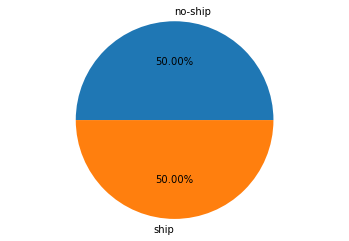

In [27]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
            explode=(0,0),
            labels=class_names,
            autopct="%1.2f%%")
    plt.axis('equal');

## One Hot Encoding Variables

The labels numpy array is one hot encoded using to_categorical from keras. This removes any uncessary bias in the dataset, by keeping the class at equal footing, with respect to labels.

In [28]:
labels = to_categorical(labels)

## Training, Validation and Testing

Training, Validation and Testing
Instead of using train_test_split the images and labels arrays are randomly shuffled using the same seed value set at 42. This allows the images and their corresponding labels to remain linked even after shuffling.

This method allows the user to make all 3 datasets. The training and validation dataset is used for training the model while the testing dataset is used for testing the model on unseen data. Unseen data is used for simulating real-world prediction, as the model has not seen this data before. It allows the developers to see how robust the model is.

In [29]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

### Spliting of data

1. 70% - Training
2. 20% - Validation
3. 10% - Testing

In [30]:
total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((4200, 48, 48, 3), (1200, 48, 48, 3), (600, 48, 48, 3))

If AUGMENTATION is set True, then the number of images per class is balanced. If AUGMENTATION is set to False, then compute the class weights given below and accordingly change the fit function of the Keras API when training.

In [31]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

### Creation of model

1. conv_block - This function contains the convulotional layer, batch normalization and activation layers. The number of filters, kernel_size, strides to be taken are defined by the developer. This allows a developer to make the model without having to repeat the same lines continuously many times. It also uses the OOPs concepts of Python which is recommended instead of coding like it is C.

2. basic_model - This function creates the model using the aforementioned function, max pooling layers and dropouts. After the specified number of convolutional layers, a flatten layer is introduced, along with dense layers so that the image can be classified. The flatten layer converts the feature map produced by the convolutional layers into a single column for classification.

For image detection in images using Faster R-CNN the feature map produced by the convolutional layers is used, i.e., the model drops the layers after the final convolutional block and passes the generated feature map to a Regional Proposal Network, which can either uses a vanilla CNN model containing fully connected layers or a Logistic Regression, Support Vector machines or Random forests. Advised to use vanilla CNN as it uses less CPU and memory, plus slightly faster and capable of giving multiple outputs if required.

#### Explanation of features

1. Conv2D - This is a 2 dimensional convolutional layer, the number of filters decide what the convolutional layer learns. Greater the number of filters, greater the amount of information obtained. <img src="/assets/img/MarineGEO_logo.png" alt="MarineGEO circle logo" style="height: 100px; width:100px;"/>
2. MaxPooling2D - This reduces the spatial dimensions of the feature map produced by the convolutional layer without losing any range information. This allows a model to become slightly more robust
3. Dropout - This removes a user-defined percentage of links between neurons of consecutive layers. This allows the model to be robust. It can be used in both fully convolutional layers and fully connected layers.
4. BatchNormalization - This layer normalises the values present in the hidden part of the neural network. This is similar to MinMax/Standard scaling applied in machine learning algorithms
5. Padding- This pads the feature map/input image with zeros allowing border features to stay.